In [4]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
#vac_template = np.load("templates/vac_ch_template.npy")
#sub_template = np.load("templates/sub_ch_template.npy")
#noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)

In [ ]:
#Optimum filter V1, adapt to the case where the trace length is longer than the template
import numpy as np
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
from numpy.lib.stride_tricks import sliding_window_view

class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        self._filter_kernel = self._kernel_fft / self._kernel_normalization
        self._kernel_td = np.real(ifft(self._filter_kernel)) * self._sampling_frequency
        
        
    def fit(self, trace):
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        amp = np.real(trace_filtered.sum(axis=-1)) * self._sampling_frequency / self._length
        chisq0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        chisq = (chisq0 - amp**2 * self._kernel_normalization) / (self._length - 2) 
        
        return amp, chisq
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._filter_kernel * trace_fft
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real((trace_fft.conj() * trace_fft / self._noise_psd_unfolded).sum()) * self._sampling_frequency / self._length
        chit_withdelay = (trace_filtered_td ** 2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind if best_ind<self._length//2 else best_ind-self._length
        
        return amp, chisq, t0

    def rolling_fit_with_shift(self, trace_long, allowed_shift_range=[-16384, 16384]):
        L = len(trace_long)
        N = self._length
        fs = self._sampling_frequency

        n_windows = L // N
        amps = np.zeros(n_windows)
        chisqs = np.zeros(n_windows)
        shifts = np.zeros(n_windows, dtype=int)
        positions = np.zeros(n_windows, dtype=int)

        for i in range(n_windows):
            start = i * N
            segment = trace_long[start:start + N]
            amp, chisq, t0 = self.fit_with_shift(segment, allowed_shift_range)

            amps[i] = amp
            chisqs[i] = chisq
            shifts[i] = t0
            positions[i] = start + t0

        return amps, chisqs, shifts, positions

    def fast_rolling_fit(self, trace_long, step=1, batch_size=10000):
        N = self._length
        fs = self._sampling_frequency
        total_windows = (len(trace_long) - N) // step + 1

        amps = []
        chisqs = []
        positions = []

        for batch_start in range(0, total_windows, batch_size):
            batch_end = min(batch_start + batch_size, total_windows)
            batch_indices = np.arange(batch_start, batch_end) * step
            batch_windows = np.stack([trace_long[i:i+N] for i in batch_indices])

            fft_windows = fft(batch_windows, axis=-1) / fs
            filtered = self._filter_kernel * fft_windows
            amp = np.real(filtered.sum(axis=-1)) * fs / N

            chisq0 = np.real(
                ((fft_windows.conj() / self._noise_psd_unfolded) * fft_windows).sum(axis=-1)
            ) * fs / N
            chisq = (chisq0 - amp**2 * self._kernel_normalization) / (N - 2)

            amps.append(amp)
            chisqs.append(chisq)
            positions.append(batch_indices)

        return np.concatenate(amps), np.concatenate(chisqs), np.concatenate(positions)



In [ ]:
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

In [5]:
trace, idx= lts.generate(
            E=7000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='NR',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

In [ ]:
test_trace = trace[0]
amps, chisqs, shifts, positions = sub_of.rolling_fit_with_shift(trace[0])
amps_fast, chisqs_fast, positions_fast = sub_of.fast_rolling_fit(trace[0])

  

In [ ]:
threshold = 15
indices = np.where(amps_fast > threshold)[0]

#checking step 1 rolling fit
len(indices)

163

In [ ]:
#checking fit_w_shift_non_overlapping window
indices = np.where(amps > threshold)[0]
len(indices)

1

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traces(traces, fs=3_906_250, offset_step=70, title="QP Traces"):
    if traces.ndim == 3 and traces.shape[0] == 1:
        traces = traces[0]

    num_channels, num_samples = traces.shape
    time_ms = np.arange(num_samples) / fs * 1000  # Time in ms

    plt.figure(figsize=(18, 12))
    
    for i in range(num_channels):
        color = 'orange' if i > 44 else 'tab:blue'
        plt.plot(time_ms, traces[i] + i * offset_step, lw=0.3, color=color)

    plt.xlabel("Time [ms]", fontsize=16)
    plt.ylabel("Offset ADC counts", fontsize=16)
    plt.title(title, fontsize=18)
    plt.xlim(0, time_ms[-1])
    plt.ylim(-10, offset_step * (num_channels + 1))
    plt.yticks([])  # Hide y-axis ticks

    plt.tight_layout()
    plt.show()


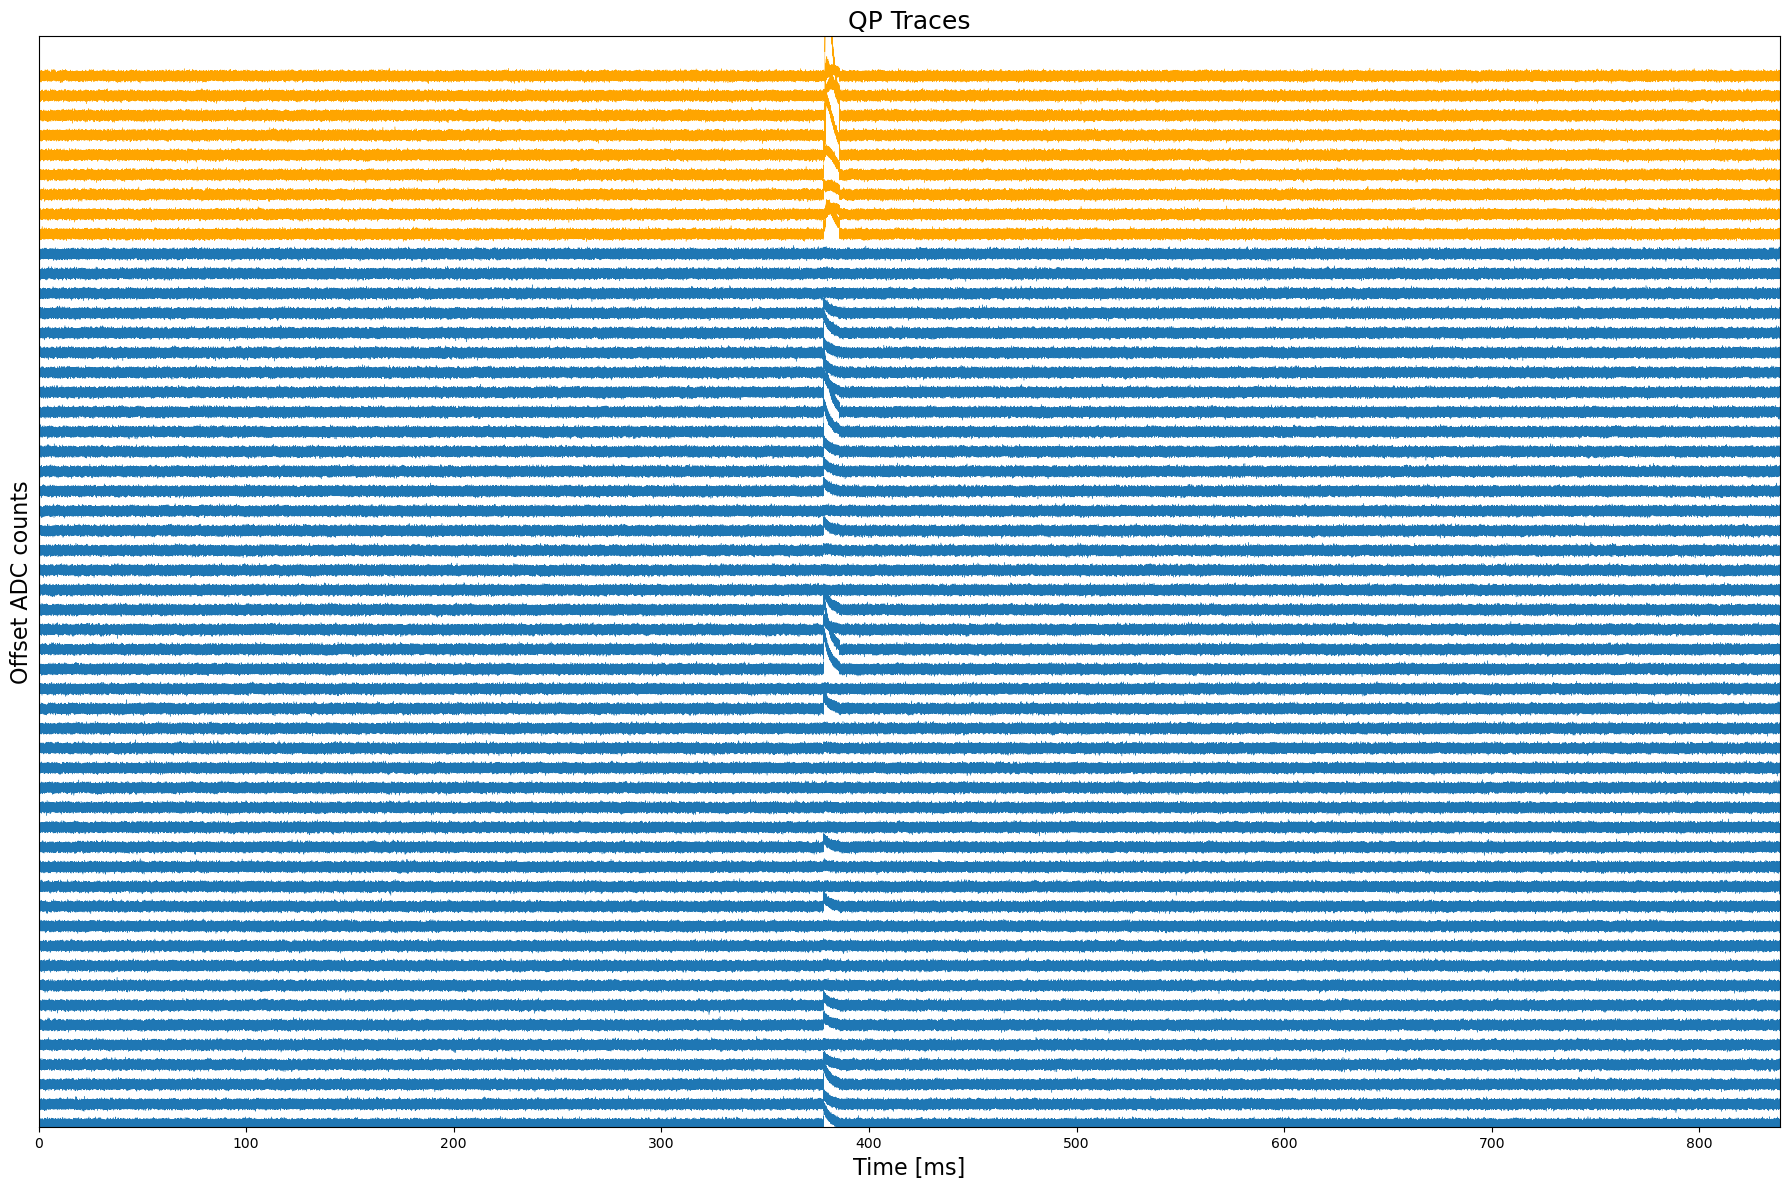

In [7]:
plot_traces(trace)

In [5]:
sub_sum.shape

(3276800,)

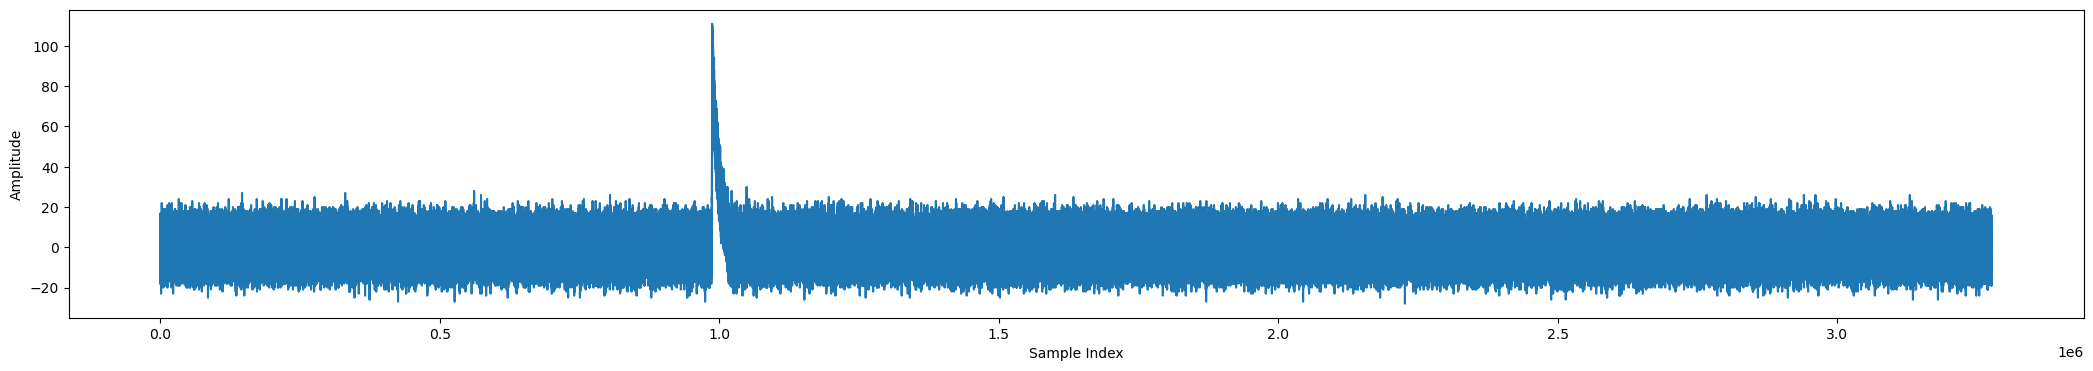

In [12]:
plt.figure(figsize=(26, 4))  # Increase width, keep moderate height
plt.plot(trace[10])
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


In [8]:
len(trace[1])

3276800